# SageMaker Models for Classification

In this notebook, we will use the two SageMaker models, Extreme Gradient Boosting model, and Linear Learner, for the classification task. For simplicity, we will limit the uses of these two models to **binary classification** only.

## Import and Process Data

In this example, we will use the Breast Cancer data. Be sure create to create a S3 your bucket, upload the data there, and change to the correct `data_location` below

In [1]:
data_name = 'breast-cancer.csv'
data_location = 'your bucket'

import pandas as pd

data = pd.read_csv(data_location + data_name)
data.head(3)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,ID,ClumpThickness,UniformityOfCellSize,UniformityOfCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0.0
1,1002945,5,4,4,5,7,10,3,2,1,0.0
2,1015425,3,1,1,1,2,2,3,1,1,0.0


Then, split into training and testing and build then apply the processing pipeline. We will also perform the transformation here since AWS models cannot be attached on top of `sklearn` pipelines, and there are a few steps to do as well.

In [2]:
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(data, test_size=0.2)

num_cols = ['ClumpThickness','UniformityOfCellSize','UniformityOfCellShape','MarginalAdhesion','SingleEpithelialCellSize','BareNuclei','BlandChromatin','NormalNucleoli','Mitoses']
target = 'Class'

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

#combining
full_pipeline = ColumnTransformer([
    ('numeric', StandardScaler(), num_cols),
])

train_features = full_pipeline.fit_transform(traindata)
test_features = full_pipeline.transform(testdata)

Next, we need to manually split training data into training and validation and upload them to S3, since models will be tuned externally in the SageMaker service, not locally in our instance with `sklearn`. The steps are
1. Split `train_features` into `train_features` and `valid_features`
2. Reorganize the training and validation data into **dataframes with the first column being the target** because this is the format required by SageMaker
3. Upload them to a folder on S3

A common practice in Python and Machine Learning is to call feature data `X` and target `Y` if we need them separated, so we will have `trainX`, `validX`, `trainY`, `validY` for the training and validation features and targets as below.

In [3]:
#further split training data to training and validation
trainX, validX, trainY, validY = train_test_split(train_features, traindata[target], test_size=0.2)

#reorganize the data in format <label - features>
#we add .values to get the numpy data instead of the pandas dataframes
import numpy as np
traindata = np.concatenate([trainY.values.reshape(-1,1), trainX],axis=1)
validdata = np.concatenate([validY.values.reshape(-1,1), validX],axis=1)

#generate csv files to upload
pd.DataFrame(traindata).to_csv('train.csv', index=False, header=False)
pd.DataFrame(validdata).to_csv('validation.csv', index=False, header=False)

Upload to a S3 folder. We will use the same bucket that we created in module 9. Furthermore, we need to access the S3 bucket with write permission, we will need to use the `boto3` library and `sagemaker` library.
- `boto3` is for general management of AWS services, including S3 and SageMaker
- `sagemaker` is for using SageMaker models and utilities

In [4]:
import sagemaker
import boto3
import os

sess = sagemaker.Session()                        # get our current SageMaker session
bucket = 'lle13-it7143'                           # this should be the name of the bucket we created in module 9
prefix = 'breast-cancer'                          # the folder to store your data in the S3 instance

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Then upload the training data under a `train` folder and validation data under the `validation` folder

In [5]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

After this point, you can go to the AWS S3 service and verify that you have the new folders and data uploaded

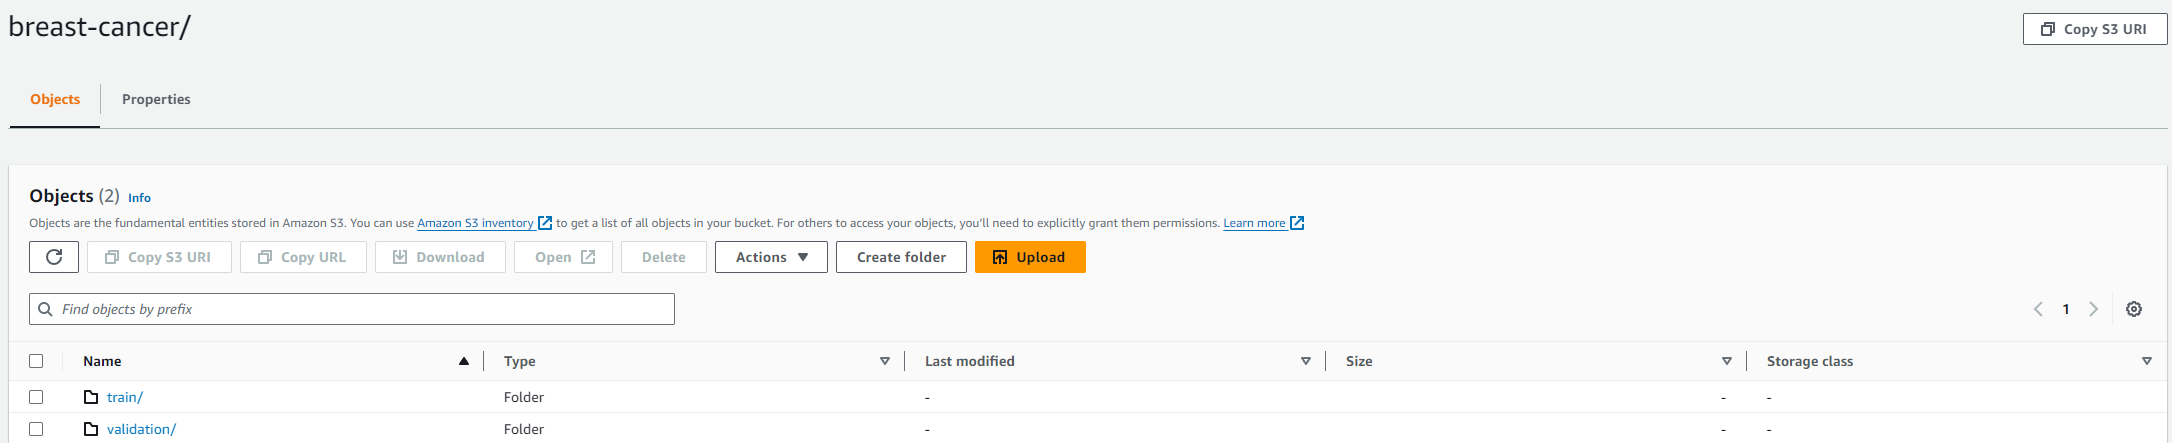

## AWS XGBoost

### Define Hyperparamter Grid

We need to create a hyperparameter dictionary similarly to in `sklearn`. A difference is that instead of explicit values like in `GridSearchCV`, we need to define the parameters as either `CategoricalParameter`, `ContinuousParameter`, `IntegerParameter`, as well as their values (`CategoricalParameter`) or range `(min, max)` (for `ContinuousParameter` and `IntegerParameter`). 

The hyperparameter grid for XGBoost is as below

In [6]:
from sagemaker_models import *

from sagemaker.parameter import CategoricalParameter, ContinuousParameter, IntegerParameter
from sagemaker.tuner import HyperparameterTuner

hyperparameter_ranges = {
    'eta': ContinuousParameter(0, 1), 
    'min_child_weight': ContinuousParameter(1, 10),
    'alpha': ContinuousParameter(0, 2), 
    'max_depth': IntegerParameter(1, 10)
}

### Build and Train the Model

Next, we build the model. While looking a bit complicated, this part can be broken down as
1. Set the path to the training and validation data on S3
2. Download the XGBoost model image from AWS 
3. Create a XGBoost model from the downloaded image
4. Set the task-related parameters
5. Create a SageMaker model tuner
6. Send the job to SageMaker service

In [9]:
#path to training and validation data
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

#download model image
from sagemaker.amazon.amazon_estimator import get_image_uri
region = boto3.Session().region_name
xgb_cont = get_image_uri(region, 'xgboost', repo_version='1.0-1')

#create model
role = sagemaker.get_execution_role()
xgb = sagemaker.estimator.Estimator(xgb_cont, role, train_instance_count=1, train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix), sagemaker_session=sess)

#set task-related parameters
xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.1,
                        tweedie_variance_power=1.4)

#create tuner
xgb_tuner = HyperparameterTuner(xgb, 
                                objective_metric_name='validation:auc', 
                                objective_type='Maximize',
                                hyperparameter_ranges=hyperparameter_ranges, 
                                max_jobs=15, max_parallel_jobs=3)

#send the tuning job to SageMaker
xgb_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................!


Training is done externally in AWS. You can go to the SageMaker console, select **Training $\rightarrow$ Hyperparameters tuning jobs** or **Training jobs** on the right menu to verify that training jobs are being done. Training will take about 10 minutes
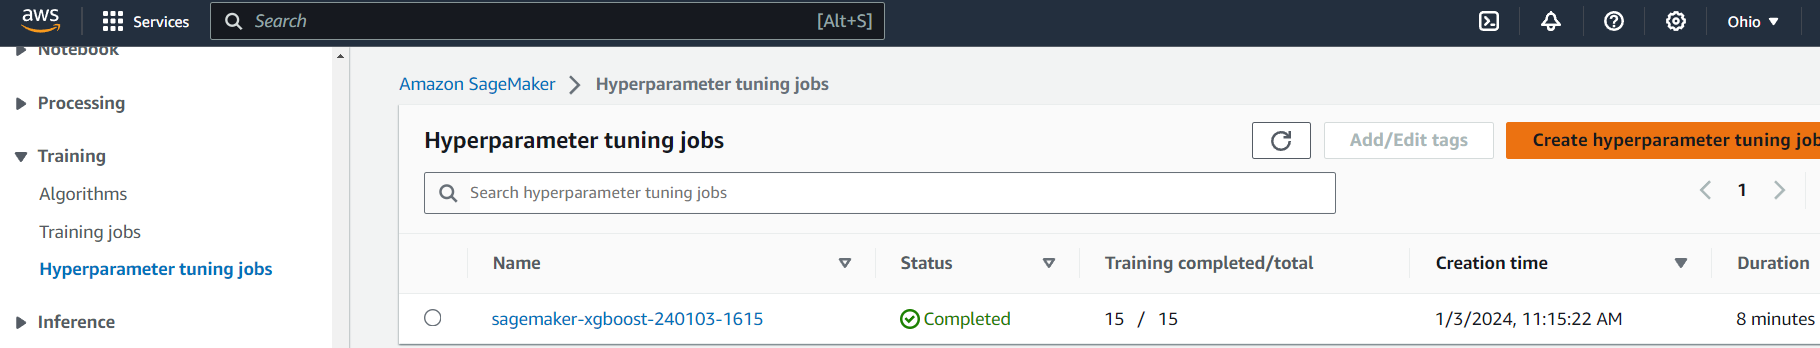
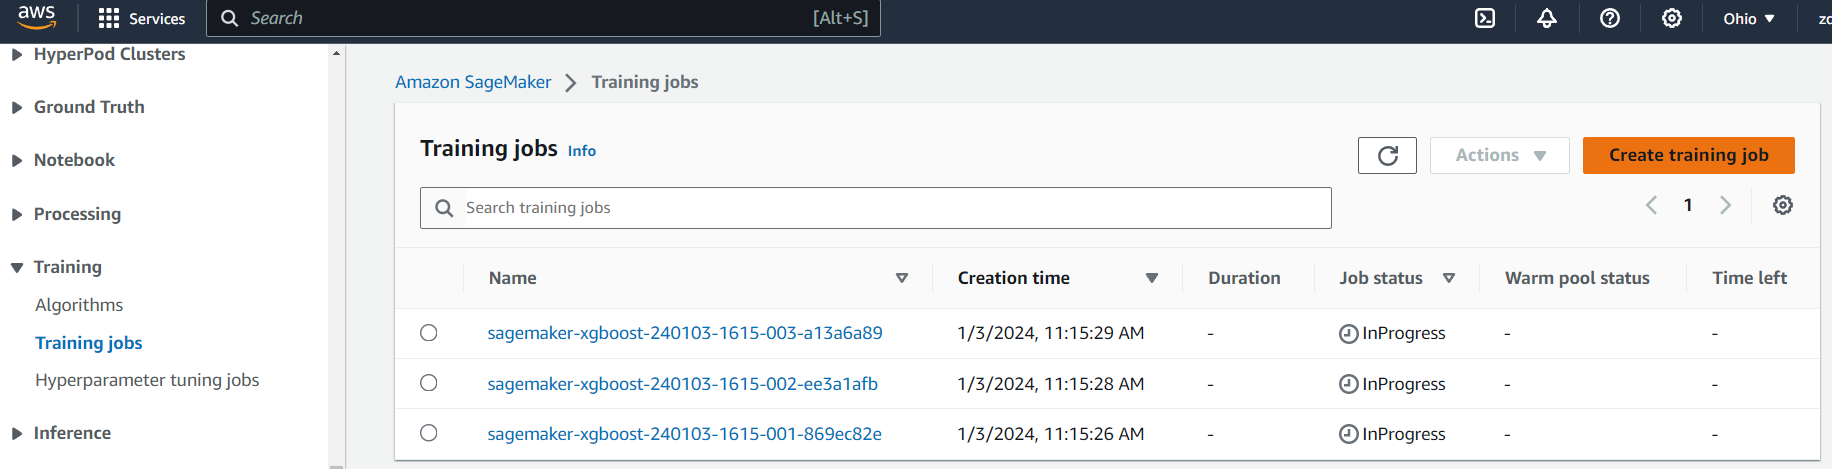

## Deploy the Model

Unlike using `sklearn` where models are local and can be used right away, SageMaker models must be **deployed** after training before we can use them.

Deploying a model will make an **endpoint** which we can use in any other session, or even build an external GUI application that runs on top of it. Endpoints are charged resources and will need to be cleaned after the session. Of course, in practice, we will keep the endpoints, not delete them.

In [10]:
best_xgboost = xgb_tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', model_name='xgboost-cls')


2024-01-03 16:22:58 Starting - Found matching resource for reuse
2024-01-03 16:22:58 Downloading - Downloading the training image
2024-01-03 16:22:58 Training - Training image download completed. Training in progress.
2024-01-03 16:22:58 Uploading - Uploading generated training model
2024-01-03 16:22:58 Completed - Resource retained for reuse
-----!

After deployment is finished, we can check the SageMaker console to verify that an endpoint has been created. On the right menu, select **Inference $\rightarrow$ Models** or **Endpoints**

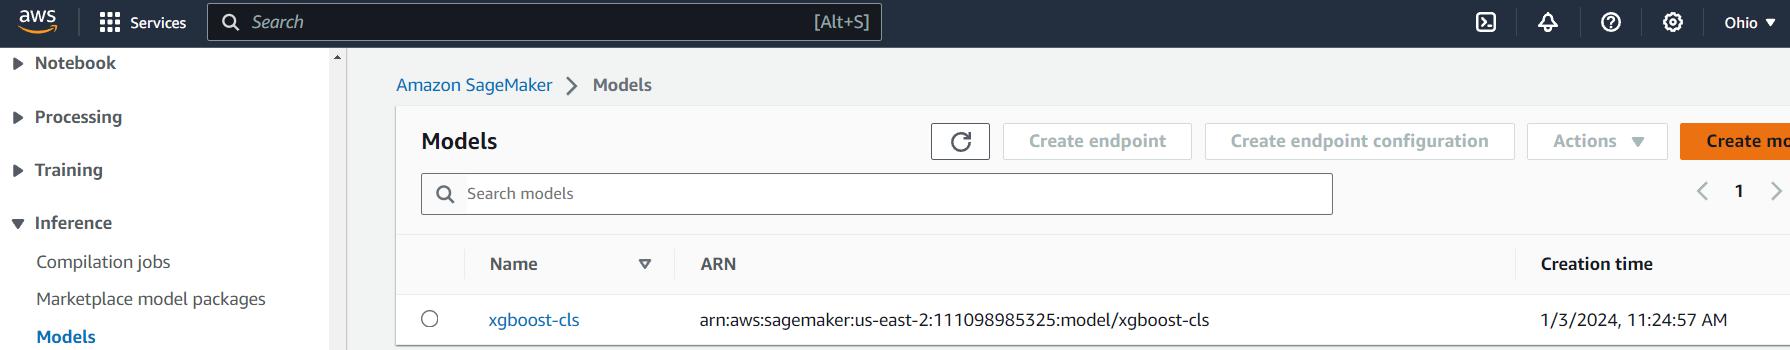

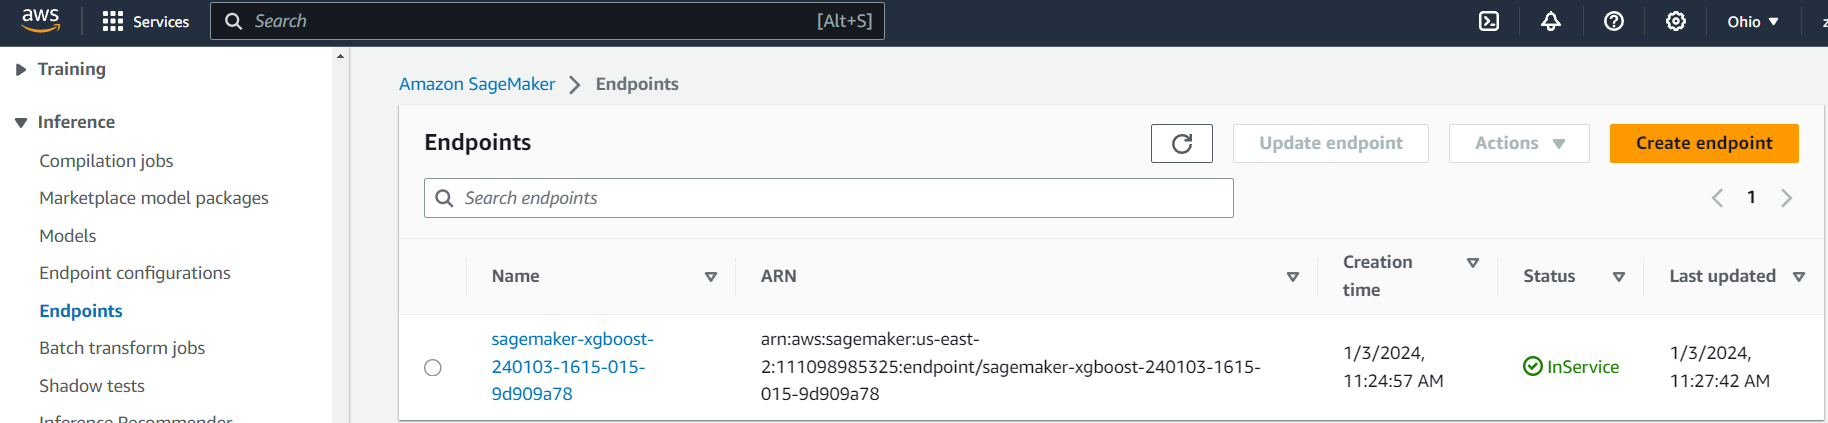


## Inference using Endpoints

Finally, we can make inferences (prediction) using the deployed endpoint. We do need to do a bit more codes here as well, since the test data needs to be serialized then sent to the endpoint. The result is returned as `utf-8` texts and needs some processing as well.

In [13]:
from sagemaker.base_serializers import CSVSerializer

best_xgboost.serializer = CSVSerializer()
predictions = best_xgboost.predict(test_features).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array

testY_pred_xgb = np.round(predictions_array)

To get accuracy and f1, we will import `accuracy_score` and `f1_score` from `sklearn`

In [16]:
from sklearn.metrics import accuracy_score, f1_score

print('xgboost accuracy: ', accuracy_score(testdata[target], testY_pred_xgb))
print('xgboost f1: ', f1_score(testdata[target], testY_pred_xgb))

xgboost accuracy:  0.9714285714285714
xgboost f1:  0.9583333333333333


<h4>Removing XGBoost Endpoint</h4>

In practice, we may want to keep the endpoint and model to use later on. However, the free tier account we use limits having only one endpoint at a time, so we need to remove xgboost endpoint before moving on to linear learner

In [19]:
best_xgboost.delete_endpoint(delete_endpoint_config=True)

## AWS Linear Learner

Very similarly to XGBoost, we need to define the hyperparameter dictionary then call the tuner function for classification linear learner. Other settings, including data and environment, are identical to XGBoost.

### Hyperparameter Ranges

In [20]:
hyperparameter_ranges = {
    "l1": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
    "wd": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
    "learning_rate": ContinuousParameter(1e-5, 1, scaling_type="Auto"),
    "mini_batch_size": IntegerParameter(100, 300, scaling_type="Auto"),
}

### Build and Train Model

Similar to XGBoost, you can go to the SageMaker console to monitor the training jobs and hyperparameter tuning jobs

In [21]:
#path to training and validation data
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='text/csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='text/csv')

#download model image
from sagemaker.amazon.amazon_estimator import get_image_uri
region = boto3.Session().region_name
ll_cont = get_image_uri(region, 'linear-learner', repo_version='1.0-1')

#create model
role = sagemaker.get_execution_role()
ll = sagemaker.estimator.Estimator(ll_cont, role, train_instance_count=1, train_instance_type='ml.m4.xlarge',
                                output_path='s3://{}/{}/output'.format(bucket, prefix), sagemaker_session=sess)

#set task-related parameters
ll.set_hyperparameters(predictor_type='binary_classifier')

#create SageMaker tuner
ll_tuner = HyperparameterTuner(ll, 
                        objective_metric_name='validation:binary_f_beta', 
                        objective_type='Maximize',
                        hyperparameter_ranges=hyperparameter_ranges, 
                        max_jobs=15, max_parallel_jobs=3)

ll_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.0-1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................!


### Deploy the Model

Similar to XGBoost, we will deploy the model to an endpoint after training.

In [22]:
best_ll = ll_tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', model_name='ll-cls')


2024-01-03 16:49:08 Starting - Found matching resource for reuse
2024-01-03 16:49:08 Downloading - Downloading the training image
2024-01-03 16:49:08 Training - Training image download completed. Training in progress.
2024-01-03 16:49:08 Uploading - Uploading generated training model
2024-01-03 16:49:08 Completed - Resource retained for reuse
-------!

### Inference

Finally, use the endpoint to make inferences/predictions. Linear learner endpoints return result in JSON format, so we need to process accordingly. Otherwise, the process are the same:
1. Set up a serializer
2. Send data to the endpoint
3. Process the returned result

In [26]:
import json
best_ll.serializer = CSVSerializer()
predictions = best_ll.predict(test_features).decode('utf-8') # predict!
testY_pred_ll = json.loads(predictions)
testY_pred_ll = (np.array([yh['score'] for yh in testY_pred_ll['predictions']]) > 0.5) * 1

Performance in accuracy and F1

In [27]:
print('linear learner accuracy: ', accuracy_score(testdata[target], testY_pred_ll))
print('linear learner f1: ', f1_score(testdata[target], testY_pred_ll))

linear learner accuracy:  0.9714285714285714
linear learner f1:  0.9574468085106383


We can see, the two models' performances are fairly similar.

# Cleaning up

**Please always run these!**

In [ ]:
# delete linear learner endpoint
best_ll.delete_endpoint(delete_endpoint_config=True)

#create session client to further clean up
sagemaker_client = boto3.client('sagemaker')

# delete models
sagemaker_client.delete_model(ModelName='xgboost-cls')
sagemaker_client.delete_model(ModelName='ll-cls')